#### Eсть данные А/А-теста. Нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации  нужно сформировать подвыборки с повторением с размером с группу пользователей из 0 и 1  экспериментальной группы. Провести сравнение этих подвыборок t-testом.

##### 1. Построить гистограмму распределения получившихся 10000 p-values.
##### 2. Посчитать, какой процент p values оказался <= 0.05.
##### 3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

In [11]:
# Подключаемся в БД.
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231220',
'user':'student',
'password':'dpo_python_2020'
}

In [12]:
# Загружаем библиотеки и модули.
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import swifter
from scipy import stats
%matplotlib inline

In [13]:
# Делаем заппрс в БД
q = '''
select  exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions
where toDate(time) >= '2023-11-11' and toDate(time) <= '2023-11-17' and  exp_group in (0,1)
GROUP BY exp_group, user_id
'''
df = ph.read_clickhouse(q, connection=connection)

In [14]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,10,34,0.294118
1,1,18392,13,56,0.232143
2,0,4504,26,71,0.366197
3,0,121508,23,109,0.211009
4,0,129565,26,159,0.163522
...,...,...,...,...,...
16814,1,23359,29,188,0.154255
16815,0,3681,13,74,0.175676
16816,1,110956,11,65,0.169231
16817,1,132567,9,27,0.333333


In [15]:
# Разбиваем на группы.
group_A = df[df.exp_group	== 0].copy()
group_B = df[df.exp_group	== 1].copy()

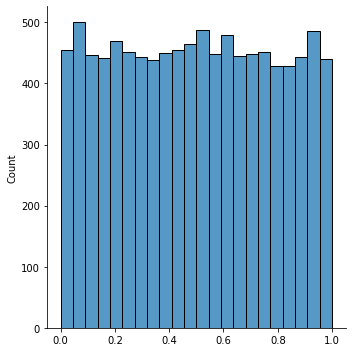

In [16]:
# Делаем выборки 10000 раз.
ps = []
for i in range(10000):
    _, p_value = stats.ttest_ind(group_A.ctr.sample(frac = 1, replace = True),\
                                 group_B.ctr.sample(frac = 1, replace = True), equal_var = False)
    ps.append(p_value)
sns.displot(ps)    

In [17]:
#Прверяем p-value.
sum(np.array(ps)<0.05)/10000

0.0506

#### Вывод: система сплитования работает  корректно.Только в 5% случаев p-value меньше 0,05.